# Notebook1 Overview:

1. Analyse dataset

2. Content-based method from lesson 

3. Recommendations with k-Nearest Neighbors


### 1. Dataset:

The dataset was downloaded:   
https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?resource=download  

anime.csv:   
anime_id :id identifying an anime.  
name : name of anime  
genre : genres for this anime  
type : movie, TV, OVA, ...  
episodes : how many episodes in this show  
rating : average rating out of 10 for this anime  
members : number of community members  

rating.csv  
user_id : user id.  
anime_id : the anime that this user has rated.  
rating : rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating)  

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

pd.set_option('display.max_colwidth', None)


2024-05-23 21:14:06.293620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load and clean dataset

In [2]:
# Load the anime dataset
anime_df = pd.read_csv('archive/anime.csv')
#anime_df = anime_df.set_index('anime_id')

anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266


In [3]:
print("Anzahl der Zeilen im DataFrame:", anime_df.shape[0])
print("Anzahl der Spalten im DataFrame:", anime_df.shape[1])


Anzahl der Zeilen im DataFrame: 12294
Anzahl der Spalten im DataFrame: 7


In [4]:
anime_df.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [5]:
non_float_ratings = anime_df[pd.to_numeric(anime_df['rating'], errors='coerce').isnull()]
non_float_ratings

,anime_id,name,genre,type,episodes,rating,members
8968,34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gendai Monogatari,"Comedy, Supernatural",TV,Unknown,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,Unknown,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super Power, Supernatural",TV,Unknown,NaN,90706
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999
...,...,...,...,...,...,...,...
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle - Revolution,Hentai,OVA,Unknown,NaN,392
12279,34491,Sagurare Otome The Animation,Hentai,OVA,1,NaN,79
12280,34312,Saimin Class,Hentai,OVA,Unknown,NaN,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,NaN,195


In [6]:
non_integer_episodes = anime_df[pd.to_numeric(anime_df['episodes'], errors='coerce').isnull()]
non_integer_episodes

,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Shounen, Super Power",TV,Unknown,8.58,504862
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,Unknown,8.25,114702
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super Power",TV,Unknown,7.94,533578
991,966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of Life",TV,Unknown,7.73,26267
1021,33157,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Special,Unknown,7.72,5400
...,...,...,...,...,...,...,...
12265,34361,Kyonyuu Reijou MC Gakuen,Hentai,OVA,Unknown,NaN,205
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle - Revolution,Hentai,OVA,Unknown,NaN,392
12280,34312,Saimin Class,Hentai,OVA,Unknown,NaN,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,NaN,195


In [7]:
index_to_drop = non_integer_episodes.index

anime_df.drop(index_to_drop, inplace=True)

In [8]:
rows_with_null_values = anime_df[anime_df.isna().any(axis=1)]
# Annahme: Überschriftstext
header_text = "Rows with NaN Values"
# Konvertiere den Text in Markdown
header_md = Markdown(f"## {header_text}")
# Zeige die Überschrift an
display(header_md)
display(rows_with_null_values)

## Rows with NaN Values

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
11111,34445,Yuuki Yuuna wa Yuusha de Aru: Yuusha no Shou,"Drama, Fantasy, Magic, Slice of Life",TV,6,NaN,4439
11112,33035,Yuyushiki Special,NaN,Special,1,NaN,2294
11113,33390,Zunda Horizon,NaN,Movie,1,NaN,160
12257,34168,Hataraku Otona no Renai Jijou The Animation,Hentai,OVA,1,NaN,331


In [9]:
anime_df.dropna(axis = 0, inplace = True)
anime_df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [10]:
print("Anzahl der Zeilen im DataFrame:", anime_df.shape[0])

Anzahl der Zeilen im DataFrame: 11830


In [11]:
unique_data_types = anime_df['episodes'].apply(type).unique()
print(unique_data_types)



# Konvertierung der Spalte 'episodes' zu numerischen Werten
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')

# Überprüfen, ob fehlerhafte Werte vorhanden sind
if anime_df['episodes'].isnull().any():
    print("Fehlerhafte Werte in der Spalte 'episodes' wurden gefunden und durch NaN ersetzt.")

unique_data_types = anime_df['episodes'].apply(type).unique()
print(unique_data_types)


[<class 'str'>]
[<class 'int'>]


In [12]:
# Load the anime datasetfrom IPython.display import display, Markdown

rating_df = pd.read_csv('archive/rating.csv')
#rating_df = rating_df.set_index('user_id')

rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [13]:
n_ratings = len(rating_df)
n_movies = rating_df['anime_id'].nunique()
n_users = rating_df['user_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique anime_id's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per anime: {round(n_ratings/n_movies, 2)}")

Number of ratings: 7813737
Number of unique anime_id's: 11200
Number of unique users: 73515
Average number of ratings per user: 106.29
Average number of ratings per anime: 697.66


In [14]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

## 2. Visualization:

In [15]:
top_anime_df = anime_df.sort_values(["rating"],ascending=False)
top_anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1,10.00,13
9595,23005,Mogura no Motoro,Slice of Life,Movie,1,9.50,62
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
9078,33607,Kahei no Umi,Historical,Movie,1,9.33,44
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665


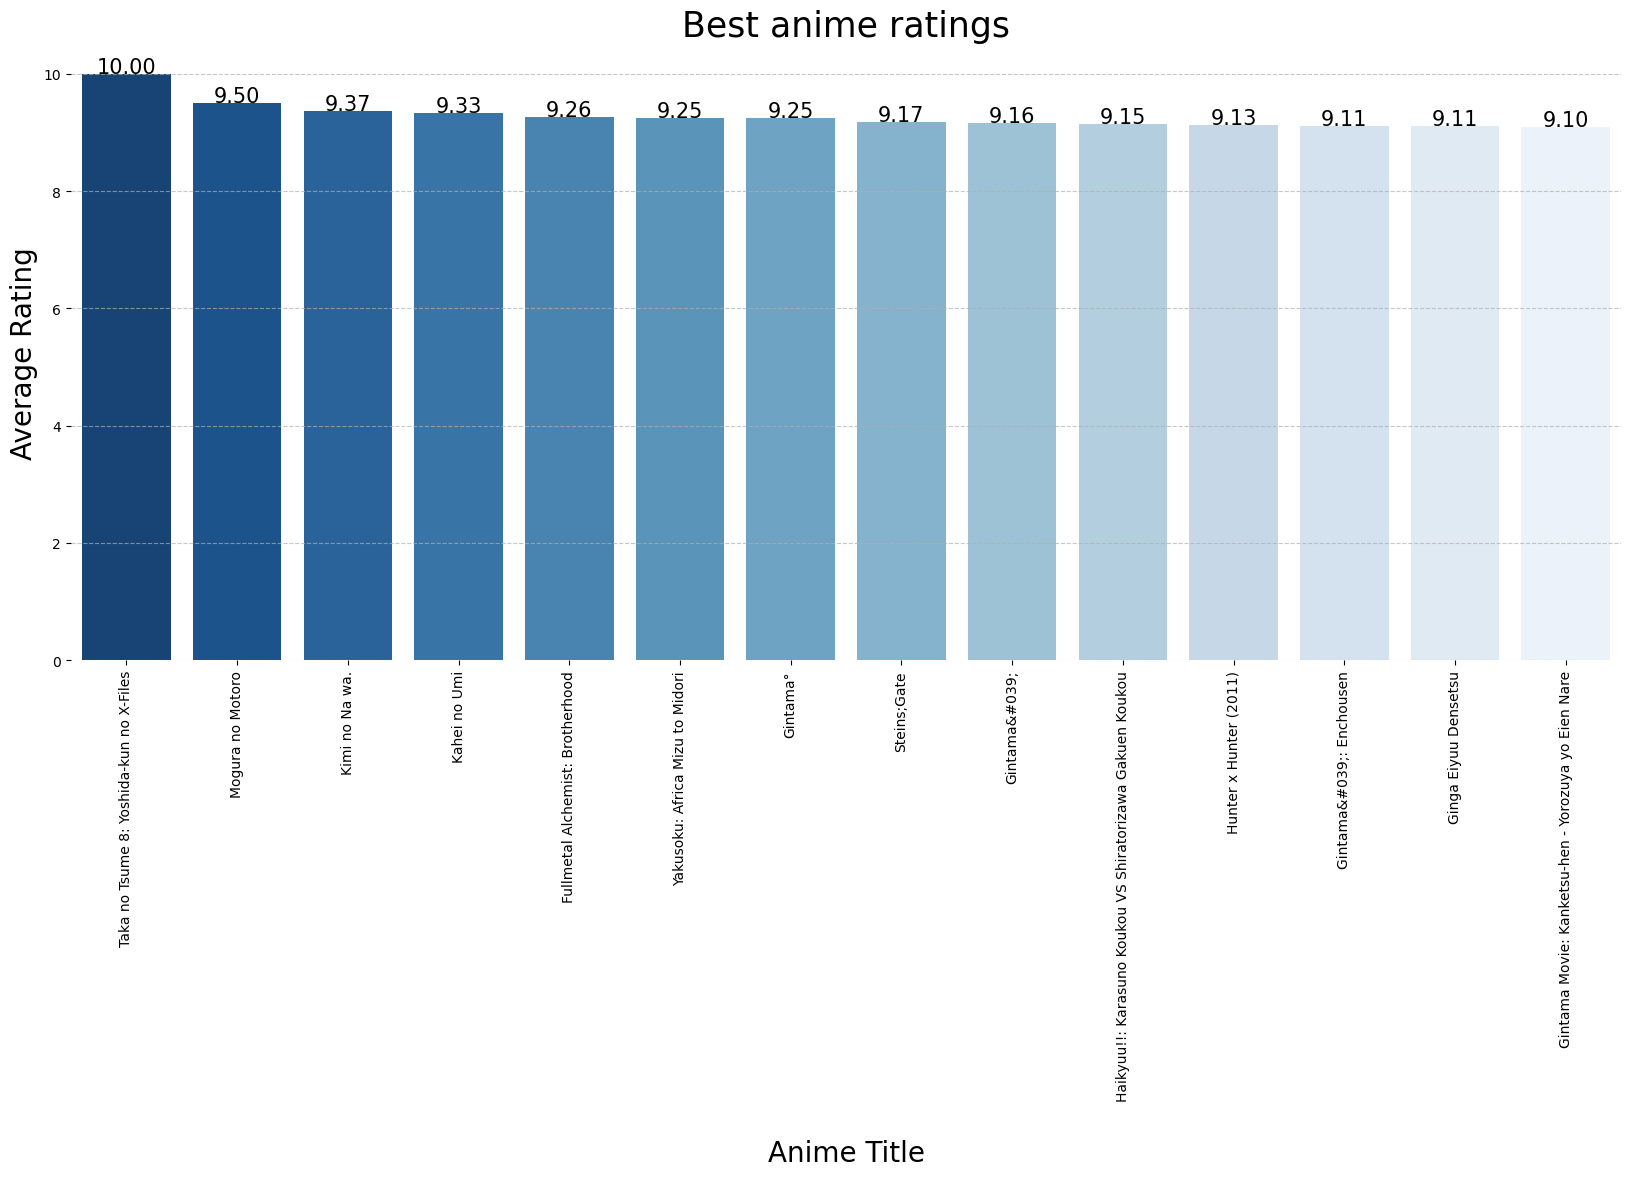

In [16]:
plt.figure(figsize=(20, 8))
p = sns.barplot(x=top_anime_df["name"][:14], y=top_anime_df["rating"], palette="Blues_r")  # Verwende ein anderes Farbschema
plt.title("Best anime ratings", fontsize=25)  # Verwende plt.title, um den Titel einzufügen
plt.ylabel("Average Rating", fontsize=20)
plt.xlabel("\nAnime Title", fontsize=20)
plt.xticks(rotation=90)

# Beschriftungen mit Anpassungen
for bar in p.patches:
    p.annotate(format(bar.get_height(), '.2f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
               size=15, xytext=(0, 5),
               textcoords='offset points')

sns.despine(left=True, bottom=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Füge ein Gitter hinzu
plt.savefig("best_anime_ratings.png")

plt.show()

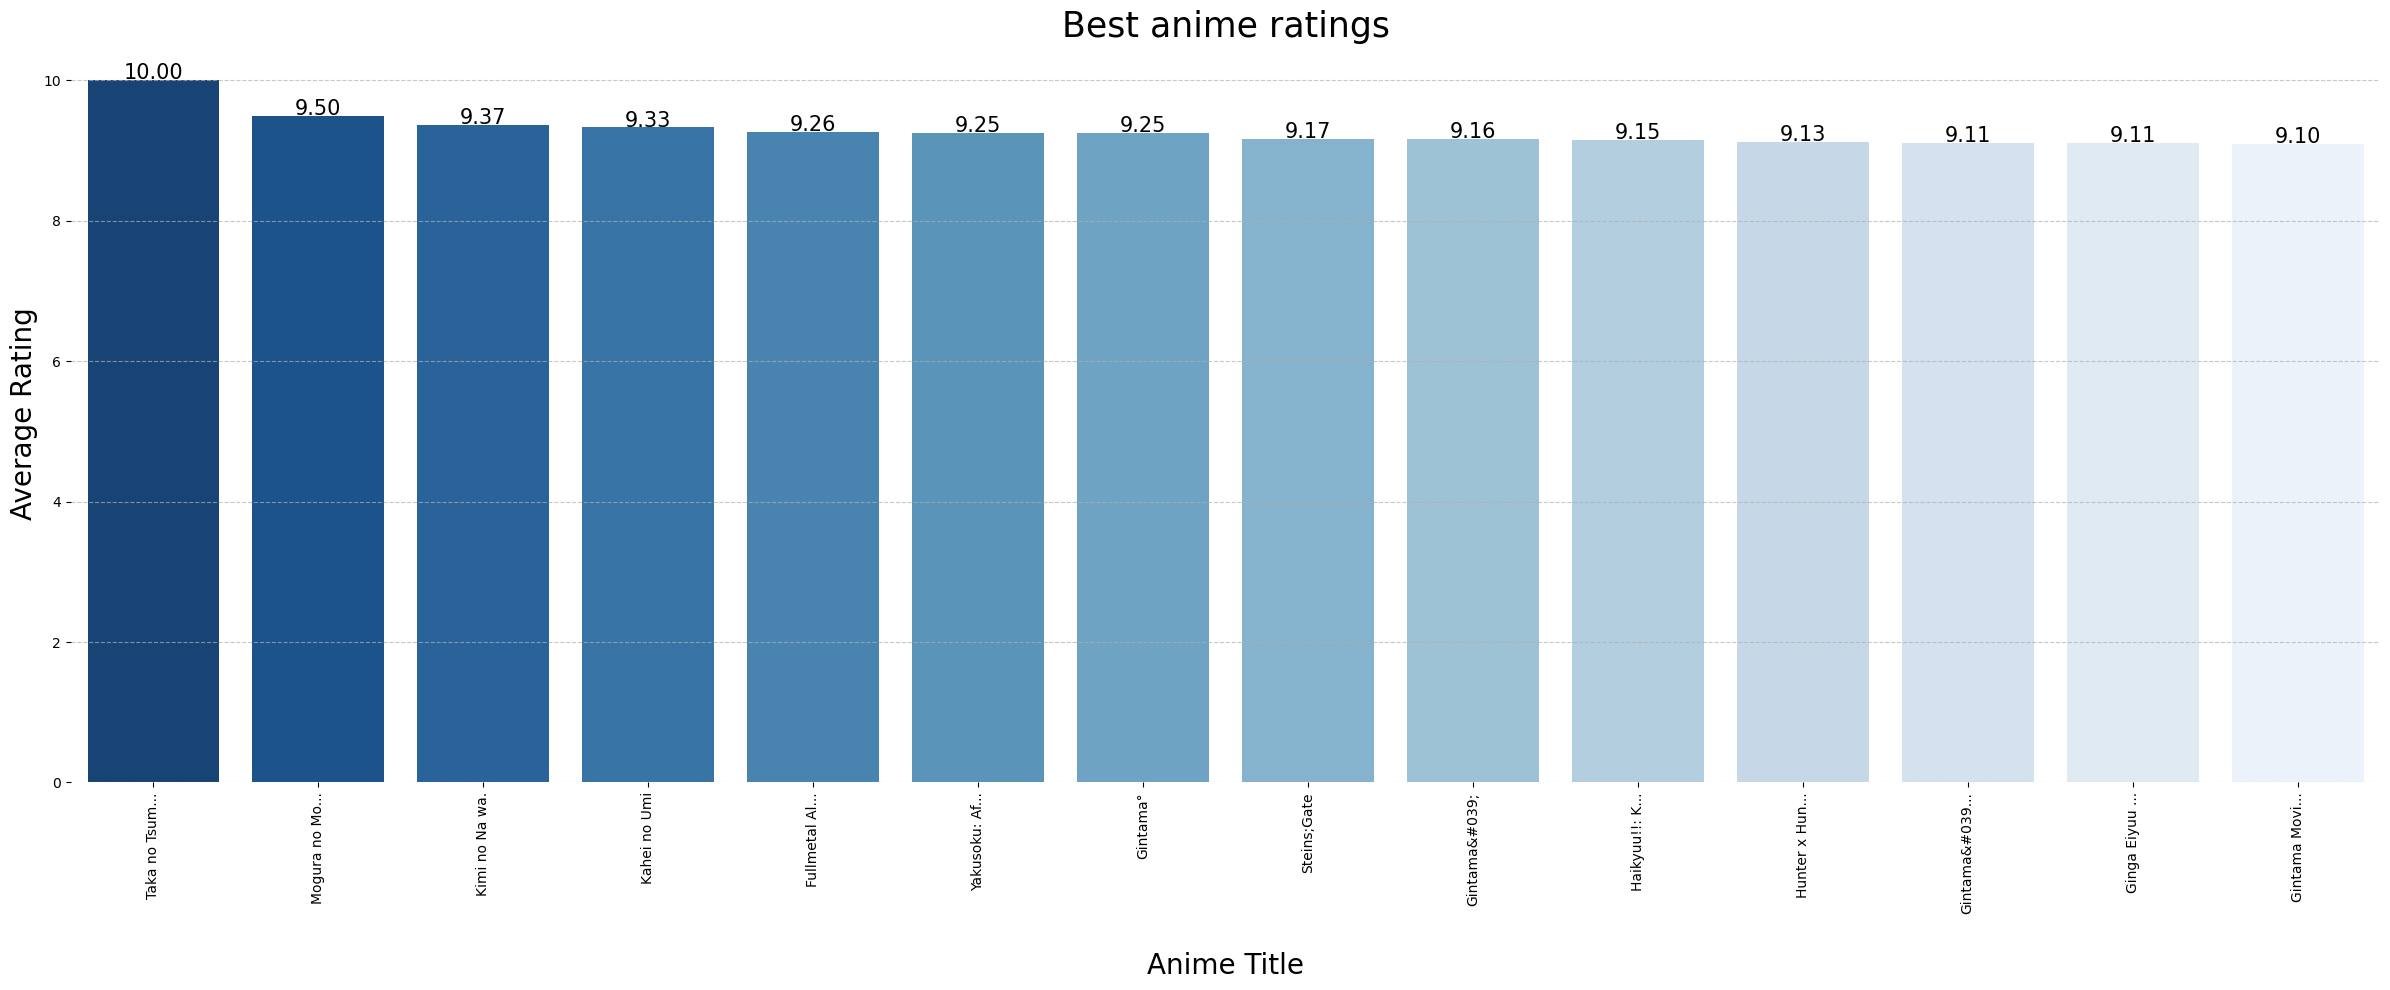

In [17]:

# Funktion zum Kürzen der Namen
def shorten_name(name, max_length=15):
    if len(name) > max_length:
        return name[:max_length-3] + '...'  # Kürzen und '...' hinzufügen
    return name

# Namen kürzen
top_anime_df['short_name'] = top_anime_df['name'].apply(shorten_name)

# Grafik erstellen
plt.figure(figsize=(24, 10))  # Vergrößere die Breite der Grafik
p = sns.barplot(x=top_anime_df["short_name"][:14], y=top_anime_df["rating"], palette="Blues_r")
plt.title("Best anime ratings", fontsize=25)
plt.ylabel("Average Rating", fontsize=20)
plt.xlabel("\nAnime Title", fontsize=20)
plt.xticks(rotation=90)

# Beschriftungen mit Anpassungen
for bar in p.patches:
    p.annotate(format(bar.get_height(), '.2f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
               size=15, xytext=(0, 5),
               textcoords='offset points')

sns.despine(left=True, bottom=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Anpassen der Ränder
plt.tight_layout()

# Grafik speichern
plt.savefig("best_anime_ratings.png")

# Grafik anzeigen
plt.show()

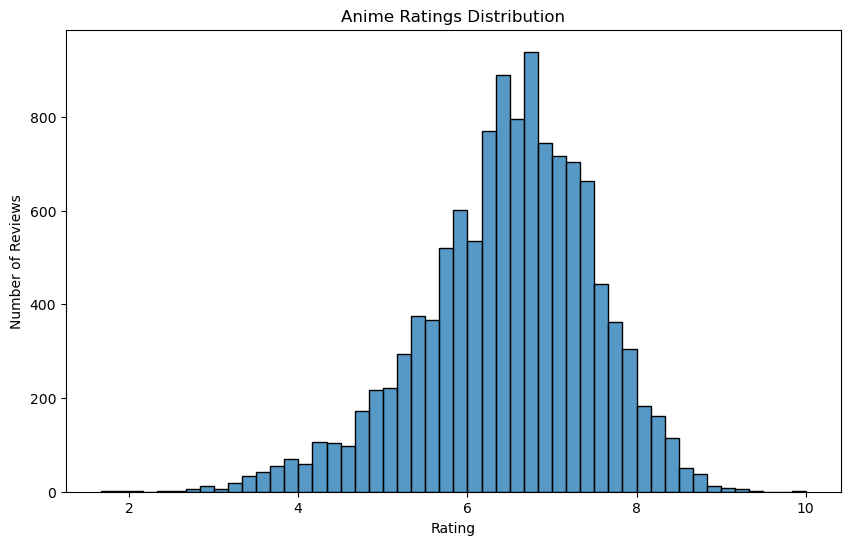

In [18]:
# Histogramm der Bewertungen erstellen
plt.figure(figsize=(10, 6))
sns.histplot(top_anime_df['rating'], bins=50)
plt.title("Anime Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.savefig("histogram.png")

plt.show()

In [19]:
top_anime_df = anime_df.sort_values(["members"],ascending=False)
top_anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796


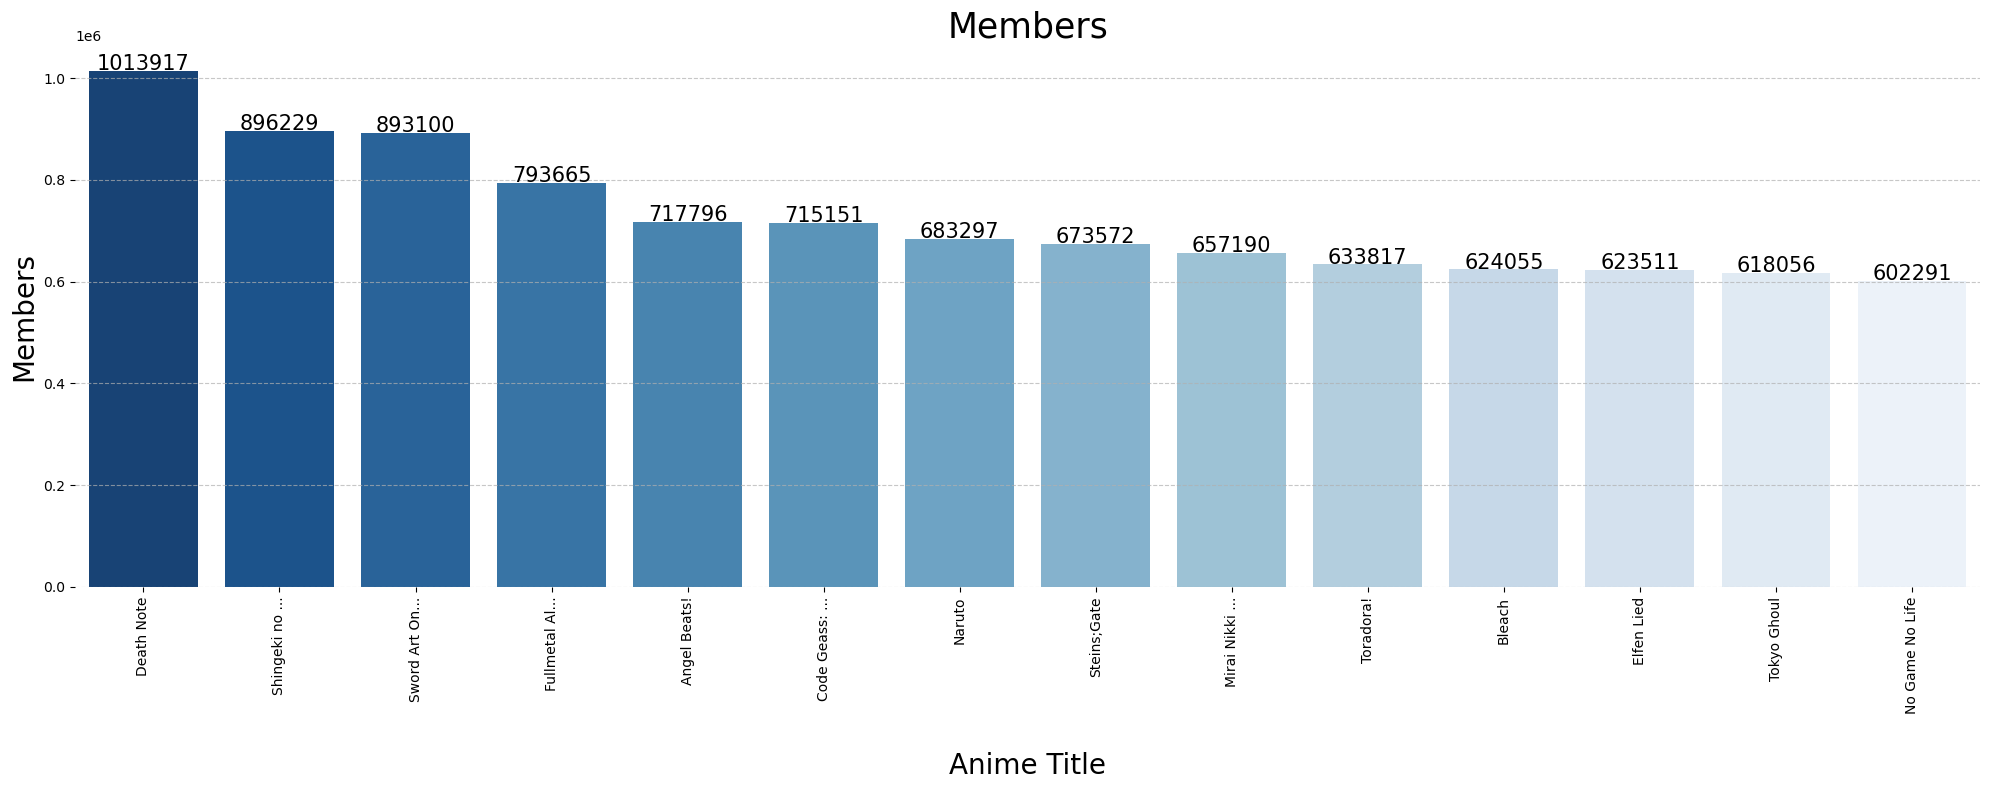

In [20]:
top_anime_df = anime_df.sort_values(["members"],ascending=False)

# Funktion zum Kürzen der Namen
def shorten_name(name, max_length=15):
    if len(name) > max_length:
        return name[:max_length-3] + '...'  # Kürzen und '...' hinzufügen
    return name

# Namen kürzen
top_anime_df['short_name'] = top_anime_df['name'].apply(shorten_name)

# Grafik erstellen
plt.figure(figsize=(20, 8))
p = sns.barplot(x=top_anime_df["short_name"][:14], y=top_anime_df["members"], palette="Blues_r")
plt.title("Members", fontsize=25)
plt.ylabel("Members", fontsize=20)
plt.xlabel("\nAnime Title", fontsize=20)
plt.xticks(rotation=90)

# Beschriftungen mit Anpassungen
for bar in p.patches:
    p.annotate(format(bar.get_height(), '.0f'),  # Zahlen als ganze Zahlen formatieren
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
               size=15, xytext=(0, 5),
               textcoords='offset points')

sns.despine(left=True, bottom=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Anpassen der Ränder
plt.tight_layout()
plt.savefig("members.png")


# Grafik anzeigen
plt.show()

In [21]:
top_anime_df["type"].value_counts().to_frame()

,count
type,
TV,3568
OVA,3246
Movie,2258
Special,1665
ONA,606
Music,487


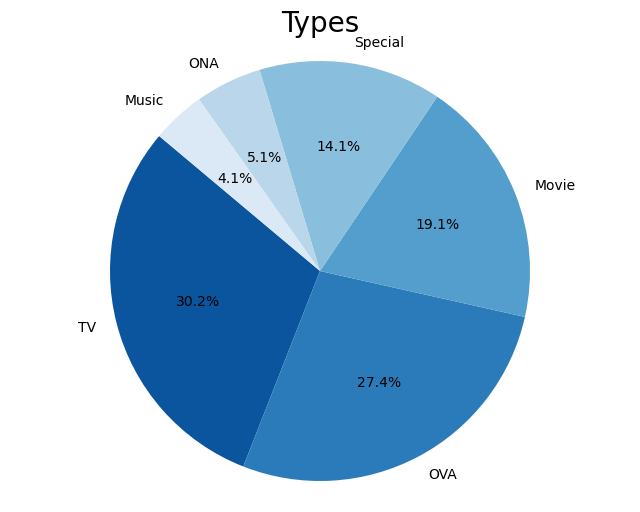

In [22]:
# Daten für das Kreisdiagramm
data = top_anime_df["type"].value_counts()

# Kreisdiagramm erstellen
plt.figure(figsize=(8, 6))
colors = sns.color_palette("Blues_r", len(data))  # Verwende die gleiche Farbpalette wie im Balkendiagramm
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Types", fontsize=20)  # Verwende plt.title, um den Titel einzufügen
plt.axis('equal')
plt.savefig("types.png")

plt.show()

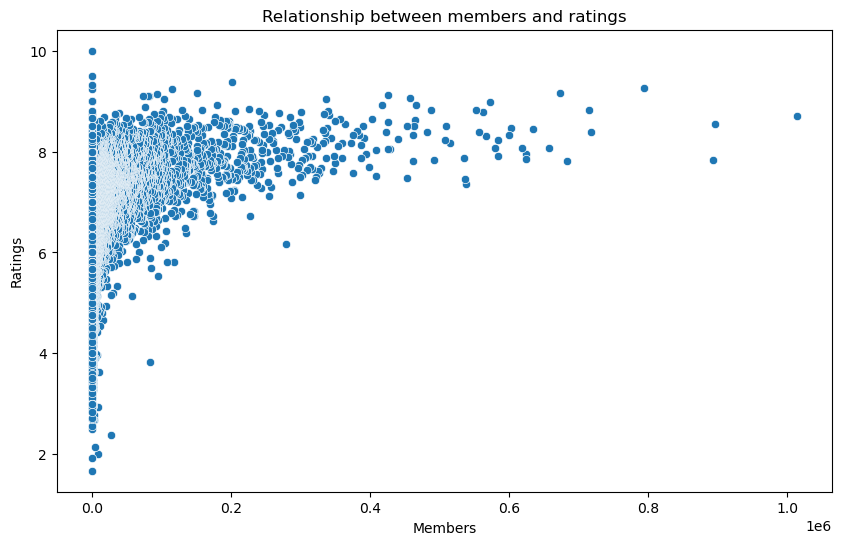

In [23]:
# Streudiagramm erstellen
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_anime_df, x="members", y="rating")
plt.title("Relationship between members and ratings")
plt.xlabel("Members")
plt.ylabel("Ratings")
plt.savefig("Relationship_Members_Ratings.png")

plt.show()

In [24]:
data_df = pd.merge(anime_df,rating_df,on="anime_id",suffixes= [None, "_user"])
data_df.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


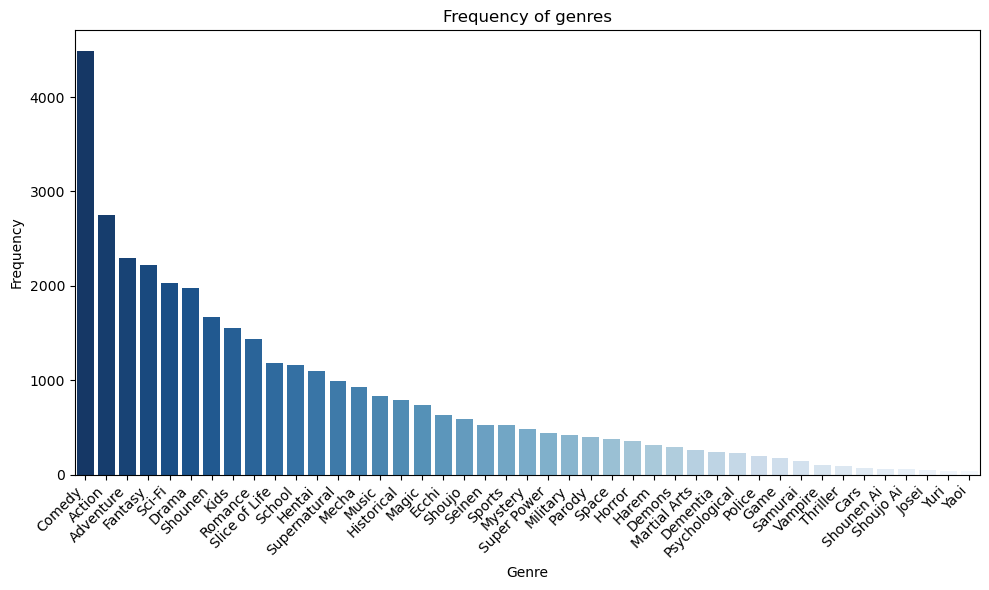

In [25]:
anime_df.head(10)

# Splitte die genre Spalte und wende dann value_counts() an
genres = anime_df['genre'].str.split(', ').explode().value_counts()

# Erstelle ein Barplot mit Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=genres.index, y=genres.values, palette="Blues_r")
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of genres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("Frequency_of_genres.png")

plt.show()

In [26]:
rating_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [27]:
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Densetsu,Hentai,OVA,1,4.98,175


## 2. Content-Based


In [28]:
anime_df['genre'] = anime_df['genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
all_genres = set(genre for sublist in anime_df['genre'] for genre in sublist)

for g in all_genres:
    anime_df[g] = anime_df.genre.transform(lambda x: int(g in x))

anime_df['type'] = anime_df['type'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
all_types = set(genre for sublist in anime_df['type'] for genre in sublist)

for g in all_types:
    anime_df[g] = anime_df.type.transform(lambda x: int(g in x))

In [29]:
anime_df

,anime_id,name,genre,type,episodes,rating,members,Ecchi,Josei,Sci-Fi,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",[Movie],1,9.37,200630,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Military, Shounen]",[TV],64,9.26,793665,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen]",[TV],51,9.25,114262,0,0,1,...,0,0,1,1,0,0,0,0,1,0
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",[TV],24,9.17,673572,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen]",[TV],51,9.16,151266,0,0,1,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,[Hentai],[OVA],1,4.15,211,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12290,5543,Under World,[Hentai],[OVA],1,4.28,183,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12291,5621,Violence Gekiga David no Hoshi,[Hentai],[OVA],4,4.88,219,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Densetsu,[Hentai],[OVA],1,4.98,175,0,0,0,...,0,0,0,0,0,1,0,0,0,0


 # Item-Feature Matrix
 The item_feature matrix is a representation of the features of each item

In [30]:
anime_df_one_hot_encoded = anime_df.drop(columns=['name', 'genre', 'type'])
anime_df_one_hot_encoded = anime_df_one_hot_encoded.rename(columns={'rating': 'average_rating'})
anime_df_one_hot_encoded = anime_df_one_hot_encoded.set_index('anime_id')
anime_df_one_hot_encoded


,episodes,average_rating,members,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,1,9.37,200630,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5114,64,9.26,793665,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
28977,51,9.25,114262,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
9253,24,9.17,673572,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9969,51,9.16,151266,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,1,4.15,211,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5543,1,4.28,183,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5621,4,4.88,219,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [31]:
item_feature= anime_df_one_hot_encoded.drop(columns=['episodes', 'average_rating', 'members'])
print(item_feature.shape)
item_feature

(11830, 48)


,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,Adventure,Horror,Game,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5114,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
28977,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
9253,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9969,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# User-Feature Matrix
matrix is used to find items that match the user's preferences by comparing their feature vectors.

In [32]:
# Zusammenführen der DataFrames

merged_df = rating_df.merge(anime_df_one_hot_encoded, left_on='user_id', right_index=True)
merged_df = merged_df.drop(columns=['anime_id', 'episodes', 'average_rating', 'members'])
merged_df


,user_id,rating,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,Adventure,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
0,1,-1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,1,-1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,1,-1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,1,-1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,1,-1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695352,34519,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3695353,34519,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3695354,34519,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3695355,34519,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
# Löschen der Zeilen mit rating -1
filtered_df = merged_df[merged_df['rating'] != -1]
filtered_df 

,user_id,rating,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,Adventure,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
47,1,10,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
81,1,10,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
83,1,10,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
101,1,10,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
302,5,8,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695352,34519,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3695353,34519,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3695354,34519,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3695355,34519,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
for i in range(2,50):
    print(filtered_df.columns[i])
    filtered_df.iloc[:,i] = filtered_df.iloc[:,i]*filtered_df['rating']

Ecchi
Josei
Sci-Fi
Harem
Mystery
Police
School
Adventure
Horror
Game
Shounen
Comedy
Vampire
Magic
Space
Shoujo
Military
Demons
Mecha
Slice of Life
Thriller
Psychological
Shounen Ai
Yuri
Samurai
Romance
Supernatural
Shoujo Ai
Music
Drama
Sports
Super Power
Seinen
Dementia
Fantasy
Parody
Hentai
Yaoi
Martial Arts
Cars
Historical
Action
Kids
OVA
ONA
Special
TV
Movie


### Drop Ratings

In [36]:
filtered_df = filtered_df.drop(columns="rating")
filtered_df

,user_id,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,Adventure,Horror,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
47,1,0,0,10,0,0,0,0,10,0,...,0,0,0,10,0,0,0,0,10,0
81,1,0,0,10,0,0,0,0,10,0,...,0,0,0,10,0,0,0,0,10,0
83,1,0,0,10,0,0,0,0,10,0,...,0,0,0,10,0,0,0,0,10,0
101,1,0,0,10,0,0,0,0,10,0,...,0,0,0,10,0,0,0,0,10,0
302,5,0,0,8,0,8,0,0,0,0,...,0,0,0,8,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695352,34519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,0,0
3695353,34519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,0,0
3695354,34519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,0
3695355,34519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,0,0


### Sum Feature Score per User

In [37]:
per_user = filtered_df.groupby('user_id').sum()
per_user

,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,Adventure,Horror,Game,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,40,0,0,0,0,40,0,0,...,0,0,0,40,0,0,0,0,40,0
5,0,0,1999,0,1999,0,0,0,0,0,...,0,0,0,1999,0,0,0,0,0,1999
7,0,0,0,0,2534,2534,0,0,0,0,...,0,0,0,2534,0,0,0,0,2534,0
8,0,0,0,0,0,0,0,100,0,0,...,0,0,0,0,0,0,0,0,100,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,0,0,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34476,0,0,480,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,480,0,0
34490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,243,0
34503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,421,0


### Normalize per User

In [38]:
sum_per_user = per_user.sum(axis=1)
sum_per_user

user_id
1          280
5        11994
7        17738
8          500
15          45
         ...  
34476     1440
34490      486
34503      842
34514    24648
34519      700
Length: 11191, dtype: int64

In [39]:
user_features = per_user.divide(sum_per_user,axis=0)
user_features

,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,Adventure,Horror,Game,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.142857,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.000000,...,0.0,0.0,0.0,0.142857,0.000000,0.0,0.000000,0.000000,0.142857,0.000000
5,0.0,0.0,0.166667,0.0,0.166667,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.000000,0.166667
7,0.0,0.0,0.000000,0.0,0.142857,0.142857,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.142857,0.000000,0.0,0.000000,0.000000,0.142857,0.000000
8,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.200000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,0.000000
15,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.200000,0.000000,0.0,0.000000,0.000000,0.200000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34476,0.0,0.0,0.333333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.000000
34490,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000
34503,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000


### User we will make recommendation

In [47]:
user = 5

In [48]:
print("Feature vector of user=", user)
print(user_features.loc[user])

Feature vector of user= 5
Ecchi            0.000000
Josei            0.000000
Sci-Fi           0.166667
Harem            0.000000
Mystery          0.166667
Police           0.000000
School           0.000000
Adventure        0.000000
Horror           0.000000
Game             0.000000
Shounen          0.000000
Comedy           0.000000
Vampire          0.000000
Magic            0.000000
Space            0.166667
Shoujo           0.000000
Military         0.000000
Demons           0.000000
Mecha            0.000000
Slice of Life    0.000000
Thriller         0.000000
Psychological    0.000000
Shounen Ai       0.000000
Yuri             0.000000
Samurai          0.000000
Romance          0.000000
Supernatural     0.000000
Shoujo Ai        0.000000
Music            0.000000
Drama            0.166667
Sports           0.000000
Super Power      0.000000
Seinen           0.000000
Dementia         0.000000
Fantasy          0.000000
Parody           0.000000
Hentai           0.000000
Yaoi        

In [49]:
print("Feature vector of user=", user)
print(user_features.loc[user])

Feature vector of user= 5
Ecchi            0.000000
Josei            0.000000
Sci-Fi           0.166667
Harem            0.000000
Mystery          0.166667
Police           0.000000
School           0.000000
Adventure        0.000000
Horror           0.000000
Game             0.000000
Shounen          0.000000
Comedy           0.000000
Vampire          0.000000
Magic            0.000000
Space            0.166667
Shoujo           0.000000
Military         0.000000
Demons           0.000000
Mecha            0.000000
Slice of Life    0.000000
Thriller         0.000000
Psychological    0.000000
Shounen Ai       0.000000
Yuri             0.000000
Samurai          0.000000
Romance          0.000000
Supernatural     0.000000
Shoujo Ai        0.000000
Music            0.000000
Drama            0.166667
Sports           0.000000
Super Power      0.000000
Seinen           0.000000
Dementia         0.000000
Fantasy          0.000000
Parody           0.000000
Hentai           0.000000
Yaoi        

In [50]:
user_features.shape

(11191, 48)

In [51]:
item_feature.shape

(11830, 48)

In [52]:
#recommended = pd.DataFrame(item_features.dot(user_features.T))
recommended = pd.DataFrame(item_feature.dot(user_features.loc[user].T))
recommended.columns = ['sim']

recommended

,sim
anime_id,
32281,0.333333
5114,0.333333
28977,0.333333
9253,0.166667
9969,0.333333
...,...
9316,0.000000
5543,0.000000
5621,0.000000


### Pick Top-10 Recommendations

It sorts the recommended DataFrame by the similarity scores in descending order.  
It selects the top 10 most similar items from the sorted DataFrame.  
It merges these top 10 recommendations with the anime_df DataFrame to include additional information about each recommended anime.  
It transposes the resulting DataFrame to swap rows and columns, likely for better readability or presentation purposes.  

In [55]:
recommended.sort_values('sim',ascending=False).head(10).merge(anime_df, left_index=True, right_index=True).T

,1901,5,1252,2202,3072,3067,219,3015,3964
sim,1.0,1.0,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333
anime_id,16732,32935,1747,460,10720,1457,23847,1953,1893
name,Kiniro Mosaic,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou,Freedom,One Piece Movie 2: Nejimaki-jima no Daibouken,Korekuraide Utau,Key the Metal Idol,Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku,Code Geass: Hangyaku no Lelouch Picture Drama,Azuki-chan
genre,"[Comedy, School, Slice of Life]","[Comedy, Drama, School, Shounen, Sports]","[Action, Adventure, Sci-Fi]","[Action, Adventure, Comedy, Fantasy, Shounen, Super Power]",[Music],"[Action, Drama, Mecha, Music, Sci-Fi]","[Comedy, Drama, Romance, School]","[Comedy, School, Slice of Life]","[Comedy, Romance, Shoujo, Slice of Life]"
type,[TV],[TV],[OVA],[Movie],[Music],[OVA],[TV],[Special],[TV]
episodes,12,10,7,1,1,15,13,9,117
rating,7.41,9.15,7.61,7.33,7.09,7.09,8.31,7.1,6.83
members,78131,93351,13918,37792,1395,7949,222994,33004,1399
Ecchi,0,0,0,0,0,0,0,0,0
Josei,0,0,0,0,0,0,0,0,0


### What are the top ratings of this User?


In [66]:
rating_user = rating_df[rating_df['user_id']==user].sort_values('rating',ascending=False).head(10).merge(anime_df, left_on='anime_id', right_index=True)
rating_user= rating_user.rename(columns={'rating_x': 'rating'})
rating_user

,anime_id,user_id,anime_id_x,rating,anime_id_y,name,genre,type,episodes,rating_y,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
338,245,5,245,10,3702,Detroit Metal City,"[Comedy, Music]",[OVA],12,8.26,...,0,0,0,0,0,1,0,0,0,0
525,9969,5,9969,9,29953,Phantasm,"[Dementia, Music]",[Movie],1,3.59,...,0,0,0,0,0,0,0,0,0,1
422,2418,5,2418,9,27539,Pikmin Short Movies,"[Fantasy, Kids]",[Movie],3,7.27,...,0,0,0,0,1,0,0,0,0,1
382,918,5,918,9,464,One Piece Movie 6: Omatsuri Danshaku to Himitsu no Shima,"[Adventure, Comedy, Fantasy, Shounen]",[Movie],1,7.77,...,0,0,0,0,0,0,0,0,0,1
440,3702,5,3702,9,29129,Ookami Shoujo to Kuro Ouji Recap,"[Comedy, Romance, School, Shoujo]",[Special],1,6.91,...,0,0,0,0,0,0,0,1,0,0
516,9253,5,9253,9,22499,Kitty to Mimmy no Happy Birthday,"[Fantasy, Kids]",[OVA],1,6.54,...,0,0,0,0,1,1,0,0,0,0


###  3. Recommendations with k-Nearest Neighbors

In [86]:
rating_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [109]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity


def find_similar_animes(anime_id, feature_matrix, anime_to_index, index_to_anime, num_recommendations, metric='cosine'):
    """
    Finds and returns a list of animes similar to the given anime based on the provided feature matrix.

    Parameters:
    anime_id (int): The ID of the anime for which similar animes are to be found.
    feature_matrix (np.array): The feature matrix where each row represents an anime and each column represents a feature.
    anime_to_index (dict): A dictionary mapping anime IDs to their indices in the feature matrix.
    index_to_anime (dict): A dictionary mapping indices in the feature matrix back to anime IDs.
    num_recommendations (int): The number of similar animes to return.
    metric (str): The distance metric to use for finding neighbors (default is 'cosine').

    Returns:
    list: A list of IDs of similar animes.
    """

    feature_matrix = feature_matrix.T
    neighbor_ids = []
    anime_index = anime_to_index[anime_id]
    anime_vector = feature_matrix[anime_index]
    if isinstance(anime_vector, np.ndarray):
        anime_vector = anime_vector.reshape(1, -1)
    knn_model = NearestNeighbors(n_neighbors=num_recommendations + 1, algorithm="brute", metric=metric)
    knn_model.fit(feature_matrix)
    neighbors = knn_model.kneighbors(anime_vector, return_distance=False)
    for i in range(1, num_recommendations + 1):  
        neighbor_index = neighbors.item(i)
        neighbor_ids.append(index_to_anime[neighbor_index])
    
    return neighbor_ids

def mapper(df):

    M = df['user_id'].nunique()
    N = df['anime_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(M))))
    anime_mapper = dict(zip(np.unique(df["anime_id"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user_id"])))
    anime_inv_mapper = dict(zip(list(range(N)), np.unique(df["anime_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [anime_mapper[i] for i in df['anime_id']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, anime_mapper, user_inv_mapper, anime_inv_mapper

X, user_mapper, anime_mapper, user_inv_mapper, anime_inv_mapper = mapper(rating_df)

In [108]:
similar_animes = find_similar_animes(1, X, anime_mapper, anime_inv_mapper, num_recommendations=10)
similar_animes

[5, 205, 6, 227, 30, 2001, 47, 889, 43, 121]

In [89]:
n_animes = anime_df['anime_id'].nunique()
print(f"There are {n_animes} unique animes in our anime dataset.")

There are 11830 unique animes in our anime dataset.


In [90]:
anime_df['genre'] = anime_df['genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
all_genres = set(genre for sublist in anime_df['genre'] for genre in sublist)

for g in all_genres:
    anime_df[g] = anime_df.genre.transform(lambda x: int(g in x))


In [91]:
anime_df['type'] = anime_df['type'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
all_types = set(genre for sublist in anime_df['type'] for genre in sublist)

for g in all_types:
    anime_df[g] = anime_df.type.transform(lambda x: int(g in x))

In [92]:
anime_df

,anime_id,name,genre,type,episodes,rating,members,Ecchi,Josei,Sci-Fi,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
0,32281,Kimi no Na wa.,[],[],1,9.37,200630,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5114,Fullmetal Alchemist: Brotherhood,[],[],64,9.26,793665,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,28977,Gintama°,[],[],51,9.25,114262,0,0,1,...,0,0,1,1,0,0,0,0,1,0
3,9253,Steins;Gate,[],[],24,9.17,673572,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,9969,Gintama&#039;,[],[],51,9.16,151266,0,0,1,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,[],[],1,4.15,211,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12290,5543,Under World,[],[],1,4.28,183,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12291,5621,Violence Gekiga David no Hoshi,[],[],4,4.88,219,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Densetsu,[],[],1,4.98,175,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [93]:
anime_df_new = anime_df.drop(columns=['anime_id', 'name', 'genre', 'type'])

anime_df_new

,episodes,rating,members,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
0,1,9.37,200630,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,64,9.26,793665,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,51,9.25,114262,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
3,24,9.17,673572,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,51,9.16,151266,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,1,4.15,211,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12290,1,4.28,183,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12291,4,4.88,219,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12292,1,4.98,175,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [94]:
non_integer_episodes = anime_df_new[pd.to_numeric(anime_df_new['episodes'], errors='coerce').isnull()]
non_integer_episodes

,episodes,rating,members,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie


In [95]:
min_A = anime_df_new['episodes'].min()
max_A = anime_df_new['episodes'].max()
anime_df_new['episodes'] = (anime_df_new['episodes'] - min_A) / (max_A - min_A)


min_A = anime_df_new['members'].min()
max_A = anime_df_new['members'].max()
anime_df_new['members'] = (anime_df_new['members'] - min_A) / (max_A - min_A)

min_A = anime_df_new['rating'].min()
max_A = anime_df_new['rating'].max()
anime_df_new['rating'] = (anime_df_new['rating'] - min_A) / (max_A - min_A)

In [96]:
anime_df_new

,episodes,rating,members,Ecchi,Josei,Sci-Fi,Harem,Mystery,Police,School,...,Martial Arts,Cars,Historical,Action,Kids,OVA,ONA,Special,TV,Movie
0,0.000000,0.924370,0.197867,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0.034673,0.911164,0.782769,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.027518,0.909964,0.112683,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
3,0.012658,0.900360,0.664323,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.027518,0.899160,0.149180,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,0.000000,0.297719,0.000196,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12290,0.000000,0.313325,0.000169,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12291,0.001651,0.385354,0.000204,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12292,0.000000,0.397359,0.000161,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [97]:
cosine_sim = cosine_similarity(anime_df_new, anime_df_new)

print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")
cosine_sim

Dimensions of our genres cosine similarity matrix: (11830, 11830)


array([[1.        , 0.26769215, 0.11961302, ..., 0.1001144 , 0.10300553,
        0.39389289],
       [0.26769215, 1.        , 0.42879723, ..., 0.07799666, 0.08022952,
        0.09082652],
       [0.11961302, 0.42879723, 1.        , ..., 0.08047084, 0.08278491,
        0.09372789],
       ...,
       [0.1001144 , 0.07799666, 0.08047084, ..., 1.        , 0.99996828,
        0.53974643],
       [0.10300553, 0.08022952, 0.08278491, ..., 0.99996828, 1.        ,
        0.54107319],
       [0.39389289, 0.09082652, 0.09372789, ..., 0.53974643, 0.54107319,
        1.        ]])

In [105]:
def recommend_anime_based_on_content(anime_title, num_recommendations=10):
    """
    Returns a list of anime recommendations based on a given anime title.

    Parameters:
    anime_title (str): The title of the anime for which recommendations are desired.
    num_recommendations (int): The number of recommendations to return.

    Returns:
    list: A list of recommended animes.
    """
    anime_index_mapping = dict(zip(anime_df['name'], list(anime_df_new.index)))
    index = anime_index_mapping[anime_title]
    similarity_scores = list(enumerate(cosine_sim[index]))
    sorted_similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_anime_indices = sorted_similarity_scores[1:(num_recommendations + 1)]
    recommended_anime_indices = [i[0] for i in top_anime_indices]
    print(f"Weil Sie {anime_title} gesehen haben, könnten Sie auch mögen:")
    recommended_animes = anime_df['name'].iloc[recommended_anime_indices]
    return recommended_animes

recommend_anime_based_on_content('Fullmetal Alchemist: Brotherhood')


Weil Sie Fullmetal Alchemist: Brotherhood gesehen haben, könnten Sie auch mögen:


200                               Fullmetal Alchemist
268                      Magi: The Labyrinth of Magic
101                        Magi: The Kingdom of Magic
795                    Densetsu no Yuusha no Densetsu
290                       Magi: Sinbad no Bouken (TV)
4264                                   Tide-Line Blue
6868                              Jikuu Tenshou Nazca
288                                        Fairy Tail
374                                       Log Horizon
1558    Fullmetal Alchemist: The Sacred Star of Milos
Name: name, dtype: object